### Clearing "scanned" ink stamp using autoencoder with Keras and TensorFlow

In this notebook I am practicing using autoencoder. As an example, I emulate a part of scanned document and then clear the ink stamp from unwanted "scanned" text.<br>

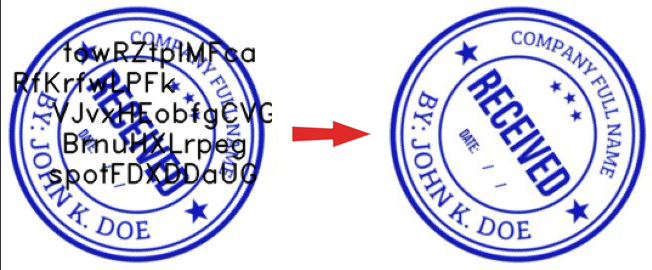


Special thanks to [**Adrian Rosebrock**](https://pyimagesearch.com/author/adrian/) from pyimagesearch.com for his excellent [**tutorial**](https://pyimagesearch.com/2020/02/17/autoencoders-with-keras-tensorflow-and-deep-learning/) !

In [1]:
!pip install imutils
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imutils
import string
import random

import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.data import AUTOTUNE

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=05be27c75666e7420366103920f55f792d56f801fc049470ddafe29122ba88d5
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


This is a helper function to show images

In [2]:
def show(image,H = 10, W = 10):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize = (H, W))
    plt.xticks([]), plt.yticks([])
    if len(image.shape) == 2:
        plt.imshow(image, cmap = 'gray')
    else:
        plt.imshow(image)
    plt.show()

Here is a sample ink stamp image I will use for training data generation

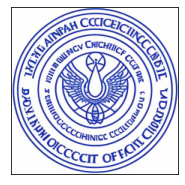

In [5]:
stamp_raw = cv2.imread('/kaggle/input/stamp-recognition-documents-with-stamps/stamps/stamps/Stamps 200/00206-2906176920.png')
SIZE = 224
stamp_raw =  imutils.resize(stamp_raw, width = SIZE, height = SIZE)
show(stamp_raw, H=3)

Using this function I generate training data randomly distorting the image. I'm applaying:<br>
-random stamp rotation<br>
-random text addition (one line)<br>
<br>
Then I invert colors and scale to 0..1 range<br>

*Color inversion has two meanings. First, it gets rid of the dark corners when you rotate the original picture. Secondly I have to feed white on black (or color on black) images to the neural network anyway.*

In [6]:
def gen_img(lines = 1):
    
    stamp = 255 - stamp_raw
    letters = string.ascii_letters
    
    ang = np.random.randint(359)
    clean = imutils.rotate(stamp, ang)
    dirty = clean.copy()
    
    pos_Y = np.random.randint(0, stamp_raw.shape[1] - 25 * lines)
    
    for i in range(lines):
        letters_num = np.random.randint(10, 15)
        pos_X = np.random.randint(0, stamp_raw.shape[0] // 4 )
    
        text = ''.join(random.choice(letters) for i in range(letters_num))
        cv2.putText(dirty,
                    text,
                    org=(pos_X, pos_Y + 25 * i),
                    fontFace=cv2.FONT_HERSHEY_DUPLEX,
                    fontScale=0.75,
                    color=(255, 255, 255),
                    thickness=1,
                    lineType = cv2.LINE_AA)
        
    dirty = dirty.astype('float32') / 255
    clean = clean.astype('float32') / 255
    
    return (dirty, clean)

Here are the sample pair of images in inversed and in normal colors:

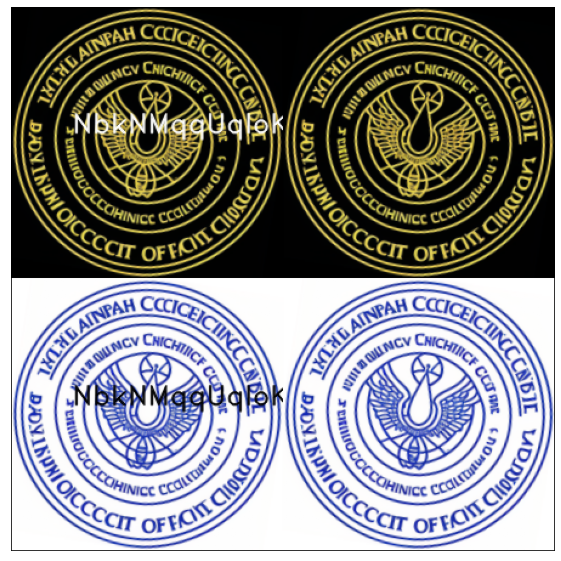

In [7]:
a, b = gen_img()
inversed = np.hstack((a, b))
show(np.vstack((inversed, 1 - inversed)))

In [15]:
TRAIN_SIZE = 50000
VALID_SIZE = 10000
BS = 32
EPOCHS = 10

Despite of the fact that I actually use the same function to generate training and validation images, TensorFlow needs seperate generators for training and for validation<br>
In order to sped up the training I will use TensofFlow ```tf.data.Dataset.from_generator``` method. You can get more details in TensorFlow [**manual**](https://www.tensorflow.org/guide/data).

In [16]:
train_gen = (gen_img() for i in range(TRAIN_SIZE * EPOCHS))
valid_gen = (gen_img() for i in range(VALID_SIZE * EPOCHS))

train_ds = tf.data.Dataset.from_generator(
        lambda: train_gen,
        output_signature=(
        tf.TensorSpec(shape=(SIZE, SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(SIZE, SIZE, 3), dtype=tf.float32)))

valid_ds = tf.data.Dataset.from_generator(
        lambda: valid_gen,
        output_signature=(
        tf.TensorSpec(shape=(SIZE, SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(SIZE, SIZE, 3), dtype=tf.float32)))


train_ds = train_ds.batch(BS).repeat().prefetch(AUTOTUNE)
valid_ds = valid_ds.batch(BS).repeat().prefetch(AUTOTUNE)

#### Autoencoder model defenition

In [17]:
class ConvAutoencoder:
    @staticmethod
    def build(width, height, depth, filters=(32, 64), latentDim=16):
        inputShape = (height, width, depth)
        chanDim = -1

        inputs = Input(shape=inputShape)
        x = inputs

        for f in filters:
            x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)

        volumeSize = K.int_shape(x)
        x = Flatten()(x)
        latent = Dense(latentDim)(x)

        encoder = Model(inputs, latent, name="encoder")

        latentInputs = Input(shape=(latentDim,))
        x = Dense(np.prod(volumeSize[1:]))(latentInputs)
        x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)

        for f in filters[::-1]:
            x = Conv2DTranspose(f, (3, 3), strides=2,
                padding="same")(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)

        x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
        outputs = Activation("sigmoid")(x)

        decoder = Model(latentInputs, outputs, name="decoder")

        autoencoder = Model(inputs, decoder(encoder(inputs)),
            name="autoencoder")

        return (encoder, decoder, autoencoder)

#### Model building

In [18]:
(encoder, decoder, autoencoder) = ConvAutoencoder.build(SIZE, SIZE, 3)
opt = Adam(learning_rate=1e-2)
autoencoder.compile(loss="mse", optimizer=opt)
encoder.summary()
decoder.summary()
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      896       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 112, 112, 32)      0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 112, 112, 32)      128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 56, 56, 64)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 56, 56, 64)        256 

#### Model training

In [19]:
%%time
H = autoencoder.fit(
    train_ds,
    validation_data = valid_ds,
    epochs=EPOCHS,
    steps_per_epoch = TRAIN_SIZE // BS,
    validation_steps = VALID_SIZE // BS)

Epoch 1/10
1562/1562 [==============================] - 125s 80ms/step - loss: 0.0150 - val_loss: 0.0076
Epoch 2/10
1562/1562 [==============================] - 124s 80ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 3/10
1562/1562 [==============================] - 124s 79ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 4/10
1562/1562 [==============================] - 124s 79ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 5/10
1562/1562 [==============================] - 124s 80ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 6/10
1562/1562 [==============================] - 124s 79ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 7/10
1562/1562 [==============================] - 124s 80ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 8/10
1562/1562 [==============================] - 125s 80ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 9/10
1562/1562 [==============================] - 124s 79ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 10/10
1562/1562 [==============================] 

#### Model serialization

In [21]:
autoencoder.save('trained_stamp_model.h5')

#### Losses

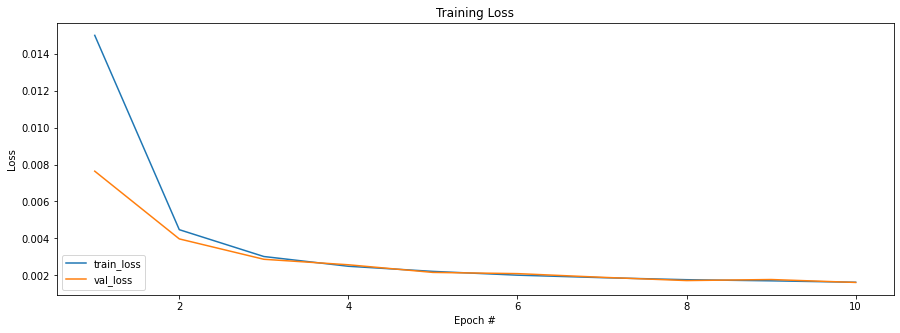

In [22]:
N = range(1,EPOCHS+1)
plt.figure(figsize = (15,5))
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.show()

#### Results
Please note that I used training pictures with just one line of text, but as you can see the model works properly with many lines of text as well.

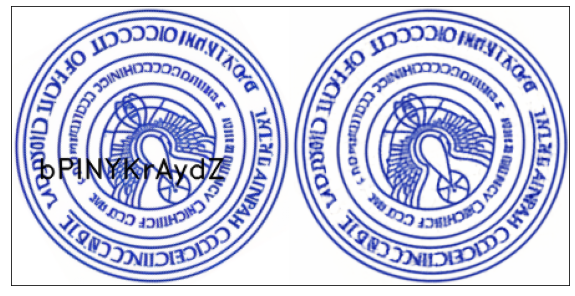

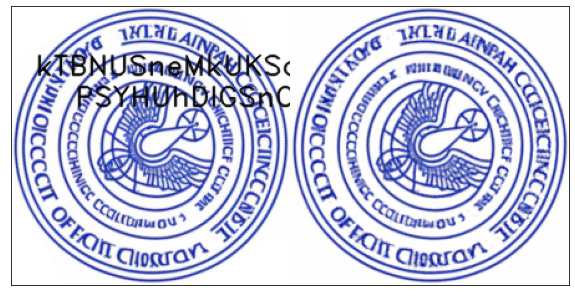

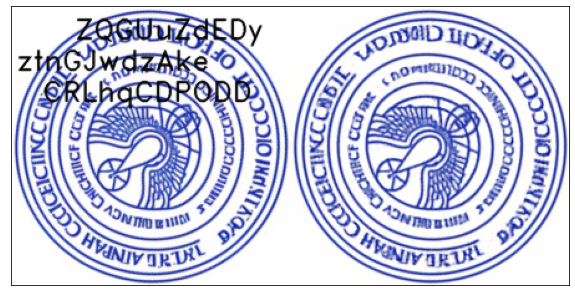

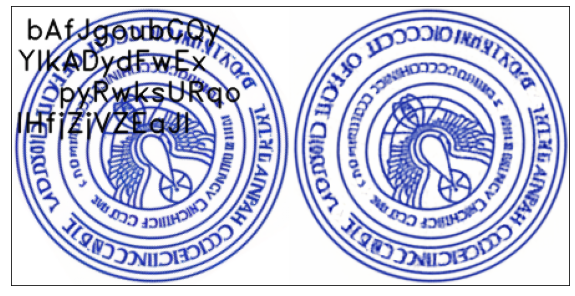

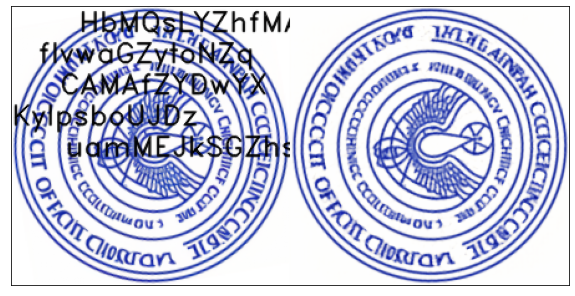

In [23]:
for i in range(1,6):
    test, _ = gen_img(i)
    test = np.expand_dims(test, 0)
    pred = autoencoder.predict(test)
    show(np.hstack((1-test[0],1-pred[0])), H=10)

In [27]:
import cv2
import imutils
import numpy as np
import string
import random

def test_img(stamp_raw, lines=1, size=224):
    """
    Generates a pair of images: one with a rotated stamp (clean) and another with added random text (dirty).
    
    Parameters:
    stamp_raw (numpy array): Input stamp image.
    lines (int): Number of lines of text to add.
    size (int): Resizing dimension for width and height.
    
    Returns:
    tuple: (dirty image with text, clean rotated stamp image)
    """
    
    #stamp_raw = imutils.resize(stamp_raw, width=size, height=size)
    stamp_raw = cv2.resize(stamp_raw, (size, size))  # Ensure both width and height match
    stamp = 255 - stamp_raw  # Invert the stamp image
    letters = string.ascii_letters
    
    ang = np.random.randint(359)
    clean = imutils.rotate(stamp, ang)  # Rotate the stamp
    dirty = clean.copy()
    
    pos_Y = np.random.randint(0, stamp_raw.shape[1] - 25 * lines)
    
    for i in range(lines):
        letters_num = np.random.randint(10, 15)
        pos_X = np.random.randint(0, stamp_raw.shape[0] // 4)
    
        text = ''.join(random.choice(letters) for _ in range(letters_num))
        cv2.putText(
            dirty,
            text,
            org=(pos_X, pos_Y + 25 * i),
            fontFace=cv2.FONT_HERSHEY_DUPLEX,
            fontScale=0.75,
            color=(255, 255, 255),
            thickness=1,
            lineType=cv2.LINE_AA
        )
    
    dirty = dirty.astype('float32') / 255
    clean = clean.astype('float32') / 255
    
    return dirty, clean

In [28]:
def test_and_predict(autoencoder, image_path):
    """
    Generates test images with increasing lines of text, feeds them into the autoencoder,
    and visualizes the results.
    
    Parameters:
    autoencoder (model): Trained autoencoder model.
    image_path (str): Path to the input image.
    """
    
    stamp_raw = cv2.imread(image_path)
    
    for i in range(1, 6):
        test, _ = test_img(stamp_raw, i)
        test = np.expand_dims(test, 0)
        pred = autoencoder.predict(test)
        show(np.hstack((1 - test[0], 1 - pred[0])), H=10)

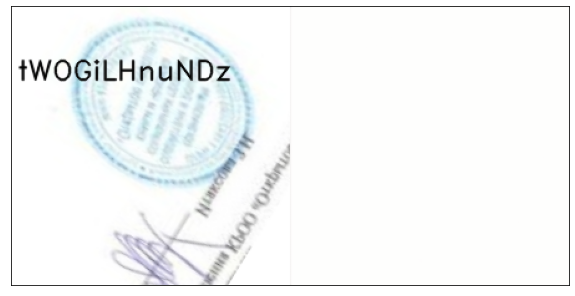

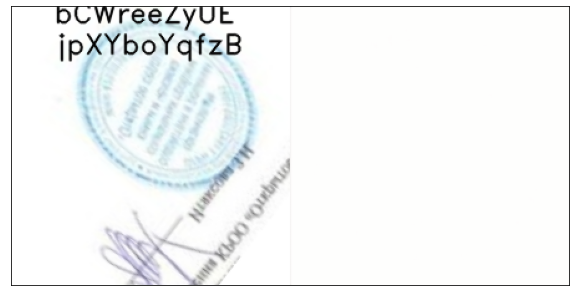

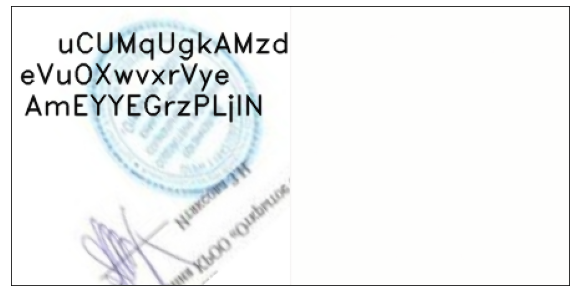

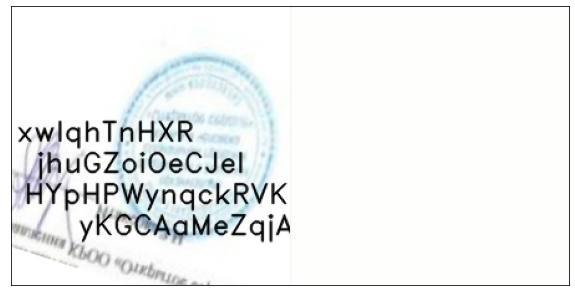

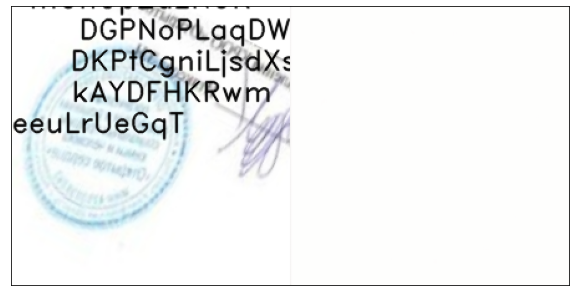

In [30]:
image_path = "/kaggle/input/overlapping-stamps/extracted_bounding_boxes/-001_jpg.rf.aec4d70a2e7864e11675647f57f9bb7d_box1_stamp_0.52.jpg"
test_and_predict(autoencoder, image_path)


#### Thank you for your attention !